### For evaluating performance of models on test data

In [2]:
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
from dataset import *
from utils import *
from nltk.translate.bleu_score import corpus_bleu
import torch.nn.functional as F
from tqdm import tqdm
import evaluate
import torch
import transformers
from transformers import RobertaTokenizerFast
from transformers import ViTFeatureExtractor
from transformers import VisionEncoderDecoderModel
import matplotlib.pyplot as plt

In [3]:
# Parameters
MAX_NEW_TOKENS=50
MAX_LEN=50
BEAM_SIZE=3

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # sets device for model and PyTorch tensors
cudnn.benchmark = True

In [5]:
rouge = evaluate.load('rouge')

### Evaluating Efficientnet LSTM model

In [18]:
data_folder = '../data/flickr8k/'  # folder with data files
data_name = 'flickr8k_5_cap_per_img_5_min_word_freq'  # base name shared by data files
checkpoint = 'effnet_lstm_model.pth.tar'  # model checkpoint
word_map_file = '../data/flickr8k/WORDMAP_flickr8k_5_cap_per_img_5_min_word_freq.json'  # word map json file

In [ ]:
# Load model
checkpoint = torch.load(checkpoint) # Use when GPU available
#checkpoint = torch.load(checkpoint,map_location ='cpu') # Use for cpu
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

In [20]:
# Load word map
with open(word_map_file, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}
vocab_size = len(word_map)

In [21]:
# Normalization transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [22]:
def eval_effnet_lstm(beam_size):
    """
    Evaluation of EfficientNet LSTM model
    
    Parameters:-
    beam_size: beam size at which to generate captions for evaluation
    
    Returns:- BLEU-4 score, ROUGE2 score
    """
    # DataLoader
    loader = torch.utils.data.DataLoader(
        CaptionDataset(data_folder, data_name, 'TEST', transform=transforms.Compose([normalize])),
        batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

    # Lists to store references (true captions), and hypothesis (prediction) for each image
    # If for n images, we have n hypotheses, and references a, b, c... for each image, we need -
    # references = [[ref1a, ref1b, ref1c], [ref2a, ref2b], ...], hypotheses = [hyp1, hyp2, ...]
    references = list()
    hypotheses = list()

    # For each image
    for i, (image, caps, caplens, allcaps) in enumerate(
            tqdm(loader, desc="EVALUATING AT BEAM SIZE " + str(beam_size))):

        k = beam_size

        # Move to GPU device, if available
        image = image.to(device)  # (1, 3, 600, 600)

        # Encode
        encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
        enc_image_size = encoder_out.size(1)
        encoder_dim = encoder_out.size(3)

        # Flatten encoding
        encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)
        encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

        # Tensor to store top k previous words at each step; initially they're just <start>
        k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

        # Tensor to store top k sequences; initially they're just <start>
        seqs = k_prev_words  # (k, 1)

        # Tensor to store top k sequences' scores; initially they're just 0
        top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

        # Lists to store completed sequences and scores
        complete_seqs = list()
        complete_seqs_scores = list()

        # Start decoding
        step = 1
        h, c = decoder.init_hidden_state(encoder_out)

        # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
        while True:

            embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

            awe, _ = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

            gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
            awe = gate * awe

            h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

            scores = decoder.fc(h)  # (s, vocab_size)
            scores = F.log_softmax(scores, dim=1)

            # Add
            scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

            # For the first step, all k points will have the same scores (since same k previous words, h, c)
            if step == 1:
                top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
            else:
                # Unroll and find top scores, and their unrolled indices
                top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

            # Convert unrolled indices to actual indices of scores
            prev_word_inds = top_k_words / vocab_size  # (s)
            next_word_inds = top_k_words % vocab_size  # (s)
            
            prev_word_inds = prev_word_inds.long()
            next_word_inds = next_word_inds.long()

            # Add new words to sequences
            seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)

            # Which sequences are incomplete (didn't reach <end>)?
            incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                               next_word != word_map['<end>']]
            complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

            # Set aside complete sequences
            if len(complete_inds) > 0:
                complete_seqs.extend(seqs[complete_inds].tolist())
                complete_seqs_scores.extend(top_k_scores[complete_inds])
            k -= len(complete_inds)  # reduce beam length accordingly

            # Proceed with incomplete sequences
            if k == 0:
                break
                
            seqs = seqs[incomplete_inds]
            h = h[prev_word_inds[incomplete_inds]]
            c = c[prev_word_inds[incomplete_inds]]
            encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
            top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
            k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

            # Break if things have been going on too long
            if step > 50:
                break
            step += 1

        # If no complete sequences, add the last incomplete sequence
        if len(complete_seqs) == 0:
            complete_seqs.extend(seqs.tolist())  # (s, step+1)
            #complete_seqs_alpha.extend(seqs_alpha.tolist())
            complete_seqs_scores.extend(top_k_scores.tolist())  # (s)
                
        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i]

        # References
        img_caps = allcaps[0].tolist()
        img_captions = list(
            map(lambda c: [w for w in c if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}],
                img_caps))  # remove <start> and pads
        references.append(img_captions)

        # Hypotheses
        hypotheses.append([w for w in seq if w not in {word_map['<start>'], word_map['<end>'], word_map['<pad>']}])

    # Calculate BLEU-4 scores
    bleu4 = corpus_bleu(references, hypotheses)
    
    # Convert index to words for rouge
    ref_rouge=[]
    for x in references:
        x_rouge=[]
        for y in x:
            y_rouge=[rev_word_map[ind] for ind in y]
            y_str=" ".join(y_rouge)
            x_rouge.append(y_str)
        ref_rouge.append(x_rouge)
    
    hypo_rouge=[]
    for x in hypotheses:
        x_rouge=[rev_word_map[ind] for ind in x]
        x_str=" ".join(x_rouge)
        hypo_rouge.append(x_str)
        
    rouge2 = rouge.compute(predictions=hypo_rouge, references=ref_rouge)['rouge2']

    return bleu4, rouge2

In [23]:
effnet_lstm_bleu4,effnet_lstm_rouge2=eval_effnet_lstm(BEAM_SIZE)

EVALUATING AT BEAM SIZE 3: 100%|██████████| 5000/5000 [1:04:33<00:00,  1.29it/s]


In [24]:
print(f'BLEU-4 score of Efficientnet LSTM model: {effnet_lstm_bleu4}')
print(f'ROUGE-2 score of Efficientnet LSTM model: {effnet_lstm_rouge2}')

BLEU-4 score of Efficientnet LSTM model: 0.20546859803315368
ROUGE-2 score of Efficientnet LSTM model: 0.24508992158890963


### Evaluating ViT RoBERTa model

In [6]:
df=create_input_df(karpathy_json_path='/home/prabhu.v/nlp_proj/data/dataset_flickr8k.json', 
                   image_folder='/home/prabhu.v/nlp_proj/data/flickr8k/Images/')

In [7]:
grouped = df.groupby(['split'])
df_test = grouped.get_group("test")
df_test = df_test.drop('split', axis=1).reset_index(drop=True)
df_test = df_test.groupby('images', as_index=False).agg(list)

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_len=MAX_LEN)
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
test_dataset = F8kDataset(df=df_test,tokenizer=tokenizer,feature_extractor= feature_extractor,decoder_max_length=MAX_LEN)

In [ ]:
model = VisionEncoderDecoderModel.from_pretrained('vit_roberta_model')

In [10]:
images=[]
for image in df_test.images:
    images.append(Image.open(image).convert("RGB"))

In [11]:
# Extract features from images
features=feature_extractor(images,return_tensors="pt").pixel_values

In [12]:
# Generate token ids for sentece
with torch.no_grad():
    generated_ids = model.generate(features,max_new_tokens=MAX_NEW_TOKENS,num_beams=BEAM_SIZE)

In [13]:
# Convert ids to words
generated_texts=tokenizer.batch_decode(generated_ids,skip_special_tokens=True)

In [14]:
# Calculate ROUGE 2 score
references=list(df_test.captions)
vit_roberta_rouge2 = rouge.compute(predictions=generated_texts, references=references)['rouge2']

In [15]:
# Convert sentence into list of tokens for corpus_bleu
hypotheses=[]
for sentence in generated_texts:
    sentence=sentence.replace('.',' .')
    tokens=sentence.split()
    hypotheses.append(tokens)
    
references=[]
for sentences in df_test.captions:
    reference=[]
    for sentence in sentences:
        tokens=sentence.split()
        reference.append(tokens)
    references.append(reference)

# Calculate BLEU 4 score
vit_roberta_bleu4 = corpus_bleu(references, hypotheses)

In [16]:
print(f'BLEU-4 score of ViT RoBERTa model: {vit_roberta_bleu4}')
print(f'ROUGE-2 score of ViT RoBERTa model: {vit_roberta_rouge2}')

BLEU-4 score of ViT RoBERTa model: 0.2339997151780256
ROUGE-2 score of ViT RoBERTa model: 0.27296918887709576


### Comparison

In [25]:
rouge2=[effnet_lstm_rouge2,vit_roberta_rouge2]
bleu4=[effnet_lstm_bleu4,vit_roberta_bleu4]
model=['EfficientNet-LSTM','ViT-RoBERTa']

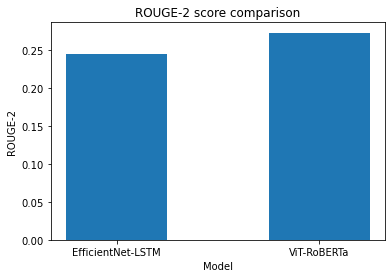

In [26]:
plt.bar(model, rouge2, width = 0.5)
plt.xlabel("Model")
plt.ylabel("ROUGE-2")
plt.title("ROUGE-2 score comparison")
plt.show()

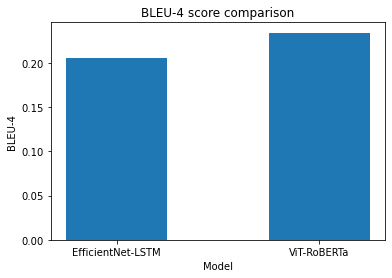

In [27]:
plt.bar(model, bleu4, width = 0.5)
plt.xlabel("Model")
plt.ylabel("BLEU-4")
plt.title("BLEU-4 score comparison")
plt.show()